# Agent with Basic Functionality and Configuration

## References 

https://www.youtube.com/watch?v=hvAPnpSfSGo


## States

In [1]:
import operator
from dataclasses import dataclass
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

from pydantic import BaseModel, Field


# TODO: separate input and output schemas
@dataclass
class InputPlanningState(TypedDict):
    pass


@dataclass
class PlanningState(TypedDict):
    """State of conversation between Agent and User."""

    project_description: Annotated[
        str, "Description of the project"
    ]  # Initial idea/explaination of the project
    messages: Annotated[
        list[str], add_messages
    ]  # Clarifying questions to refine the project idea

    project_plan: Annotated[list[str], operator.add]  # generated by Agent/s


class SearchQuery(BaseModel):
    """Agent will use this to search for information."""

    query: str = Field(..., description="The query to search for")


## Strategy Pattern for Model Providers

In [2]:
from abc import ABC, abstractmethod
from typing import Any

from langchain_core.language_models.chat_models import BaseChatModel
from langchain_openai import ChatOpenAI


class LLMProvider(ABC):
    """Abstract base class for LLM providers."""

    def __init__(self) -> None:
        """Initialize the LLM provider."""
        self.llm = None

    @abstractmethod
    def _create_llm_instance(self) -> BaseChatModel:
        """Abstract method to create LLM instance.

        This must be implemented by subclasses/Providers.
        """
        raise NotImplementedError

    def __getattr__(self, name: str) -> Any:
        """Delegate attribute access to the underlying LLM instance.

        This is the magic that allows us to call methods like `invoke`,
        `stream`, etc., directly on an `LLMProvider` instance, and they
        will be forwarded to the actual `self.llm` object (e.g., ChatOpenAI).
        """
        if self.llm is None:
            raise AttributeError(
                f"'{self.__class__.__name__}' has no LLM instance. The LLM client may not be initialized yet."
            )
        return getattr(self.llm, name)


class OpenAIProvider(LLMProvider):
    """Concrete LLM provider for OpenAI models."""

    def __init__(
        self, model_name: str = "gpt-4o", temperature: float = 0.0, **kwargs
    ) -> ChatOpenAI:
        """Initialize the OpenAIProvider."""
        self.model_name = model_name
        self.temperature = temperature
        self.kwargs = kwargs
        self.llm = self._create_llm_instance()

    def _create_llm_instance(self) -> BaseChatModel:
        """Concrete LLM provider for OpenAI models."""
        try:
            return ChatOpenAI(
                model=self.model_name, temperature=self.temperature, **self.kwargs
            )
        except Exception as e:
            raise RuntimeError(f"Failed to create ChatOpenAI instance: {e}")


## Create a Web Search Tool

In [ ]:
PROJECT_CLARIFICATION_PROMPT = """ 
You are an expert AI Software Architect and with more than 10 years of SW development and design experience. Your primary role is to analyze user's project description and interact with the user to gather all necessary details for their software project idea. You are the initial point of contact and must ensure that the project idea and description is fully understood before it moves to the planning phase.

Objective: To extract clear, concise, and comprehensive information about the user's software project idea by asking targeted, clarifying questions. Your goal is to turn a high-level concept into a set of actionable requirements.

Constraints:
* Do not attempt to plan or design the project yourself. Your sole focus is information gathering.
* Do not generate code or perform research at this stage.
* Do not make assumptions. If something is unclear, ask.

Process:
* Initial Acknowledgment: Start by acknowledging the user's project idea and expressing your readiness to help gather details.
* Iterative Questioning: Engage in a conversational loop, asking one or a few related clarifying questions at a time. Wait for the user's response before asking more.
* Broad to Specific: Begin with broader questions to understand the overall scope, then progressively narrow down to specific features, functionalities, and constraints.
* Confirmation: Periodically summarize your understanding and ask the user to confirm if it's accurate or if anything needs adjustment.
* Completion Signal: Once you believe you have a sufficiently detailed understanding of the project, state that you have gathered enough information and are ready to pass it to the "Planning Agent." then end the conversation with a "Planning Agent" signal.

Project Description is following:
{project_description}
"""

In [ ]:
PROJECT_RESEARCH_AGENT_PROMPT = """ You are an expert AI Software Architect with over 10 years of experience in software development and design.
Your primary responsibility is to read and understand the user's project description (from earlier conversation rounds), and then research all relevant topics, technologies, and best practices needed for successful implementation.

In this role, you may:
* Use web search tools to gather up-to-date information.
* Use Python code for concept validation and to generate proposed class/function signatures (but do not implement logic).
* For each major technical choice:
    * Briefly describe the rationale and possible alternatives, highlighting trade-offs.
    * Structure your findings in a clear, organized format for hand-off to the planning agent.
After completing your research, aggregate your discoveries—including annotated code structures, technology recommendations, and best-practice notes—into a concise report.
"""

In [ ]:
PLANNING_AGENT_SYSTEM_PROMPT = """ 
1. your Persona and Prime Directive
You are an expert AI Software Architect with over 10 years of experience in software development and design. Your primary goal is to understand privous project information collection conversation and research agents results and transform it into a comprehensive, actionable, and well-structured project blueprint. You must act as a technical co-founder, thinking critically about the project's feasibility, architecture, and phased rollout. Your final output must be a detailed steps plan suitable for direct use in project management tools like GitHub Projects. Keeping mind that You are instructing a Single/Solo Computer vision and AI Engineer (with 5 years of experience in python) to create a project plan.
2. Your Tasks:
    * Step-by-Step Project Plan: Generate a detailed, stepwise plan for the project, starting from the MVP (Minimum Viable Product) to advanced feature implementations.
    * Feature Progression: Clearly outline which features are part of the MVP and how to incrementally add advanced features, with justification for the order of implementation.
    * Design Patterns: Recommend specific design patterns for each major component or step, explaining why each is suitable and how to implement it in the context of the project.
    * Project Structure: Suggest a logical and scalable project folder/file structure, following best practices for the chosen tech stack.
    * Best Practices: List the best practices relevant to the project, including coding standards, testing, documentation, CI/CD, and collaboration tips.
    * Frameworks & Technologies: Recommend the most suitable frameworks, libraries, and technologies for the project, with reasons for each choice.
    * Markdown Output: Present the entire project plan in well-formatted Markdown, using headings, subheadings, bullet points, and tables where appropriate. The output should be directly usable for creating GitHub issues and Kanban board tasks.
    * Tool Usage: You may use external tools and sources (e.g., Python, Wikipedia, TavilySearch) to gather information and improve your recommendations.
 """

In [ ]:
SYSTEM_PROMPT_PROJECT_PLAN_STRUCTURE = """You are a report generation agent. Below is the researched information about the project plan:  
{PROJECT_PLANNING_RESEARCHED_INFORMATION}

**Your task:**  
Using only the provided information, generate a final project plan in the exact Markdown format below.
If any section lacks information, state “N/A” for that item.

# Project Blueprint: [Project Name]

## 1. Executive Summary
A brief, high-level overview of the project and the proposed technical approach. Summarize the core problem and the solution.

## 2. Technology Stack Recommendation
Provide a table of recommended technologies and a detailed justification for each choice, including possible trade-offs.

| Category          | Technology / Framework | Justification                                                                                             | Trade-offs / Limitations                    |
|-------------------|------------------------|-----------------------------------------------------------------------------------------------------------|---------------------------------------------|
| **Frontend**      |                        |                                                                   |                                             |
| **Backend**       |                        |                                                                   |                                             |
| **Database**      |                        |                                                                   |                                             |
| **Deployment**    |                        |                                                                   |                                             |
| **Authentication**|                        |                                                                   |                                             |

## 3. Project Structure & Architectural Patterns
Provide a recommended folder structure and explain the key design patterns to be used.

### Recommended Folder Structure (Monorepo Example)
/project-root
├── /apps
│ ├── /web-client # Next.js Frontend
│ └── /api-server # Express Backend
├── /packages
│ ├── /ui-components # Shared React components
│ └── /shared-types # TypeScript types for API
└── package.json

### Key Design Patterns
| Pattern Name                | Where to Apply                     | Rationale                                                              | Trade-offs / Notes                   |
|-----------------------------|------------------------------------|------------------------------------------------------------------------|--------------------------------------|
| **Model-View-Controller**   | Backend API structure              | Separates concerns, making the application easier to maintain and scale.|                                      |
| **Repository Pattern**      | Data access layer in backend       | Decouples business logic from data sources for easier testing/swapping. |                                      |
| **Component-Based Arch.**   | Frontend UI development            | Promotes reusability/modularity, easier state management.               |                                      |


## 4. Phased Development Plan (MVP to Full Launch)
Divide the development into sequential phases. Make each feature a checklist item. If not specified, mark as “N/A”.

### **Phase 1: Minimum Viable Product (MVP)**
- [ ] **Feature:** 
- [ ] **Chore:** 

### **Phase 2: Core Features (V1.0)**
- [ ] **Feature:**
- [ ] **Chore:** 

### **Phase 3: Advanced Features (V1.1+)**
- [ ] **Feature:**

## 5. Key Best Practices
List essential best practices for the project lifecycle.
- Version Control:
- Testing:
- Code Quality:
- Security:
- Documentation:

## (Optional) 6. Extensions & Future Work
Suggest possible future enhancements or research directions for this project.

"""


In [4]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langgraph.errors import NodeInterrupt

# Search query writing
SEARCH_INSTRUCTIONS = SystemMessage(
    content="""You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query"""
)


tavily_search = TavilySearch(max_results=3)


@tool
def search_web(state: PlanningState) -> PlanningState:
    """Retrieve information from the web."""
    structured_llm = llm.with_structured_output(SearchQuery)
    project_description = state.project_description
    search_query: SearchQuery = structured_llm.invoke(
        [SEARCH_INSTRUCTIONS.format(project_idea=project_description)]
        + state["messages"]
    )
    search_docs = tavily_search.invoke(search_query.query)
    # format
    formatted_search_docs = [
        f"""<Document href='{doc["url"]}'messages/>\n{doc["content"]}\n<Document>"""
        for doc in search_docs
    ]

    return {"project_plan": [formatted_search_docs]}


@tool
def search_wikipedia(state: PlanningState) -> PlanningState:
    """Retrieve information from Wikipedia."""
    structured_llm = llm.with_structured_output(SearchQuery)

    project_description = state.project_description

    search_query: SearchQuery = structured_llm.invoke(
        [SEARCH_INSTRUCTIONS.format(project_description=project_description)]
        + state["messages"]
    )
    search_docs = tavily_search.invoke(search_query.query)
    # format
    formatted_search_docs = [
        f"""<Document href='{doc["url"]}'/>\n{doc["content"]}\n<Document>"""
        for doc in search_docs
    ]

    state.project_plan = [formatted_search_docs]
    return {"project_plan": [formatted_search_docs]}


#  TODO: add Python tool

TOOLS = [search_wikipedia]  # search_wikipedia]

In [5]:
# search_web.invoke(PlanningState(project_description="I want to build a chatbot"))

In [6]:
# TODO: add router function to route between tools and llm or end

## Configuration


In [7]:
from langgraph.checkpoint.memory import MemorySaver

thread = {"configurable": {"thread_id": "1"}}

## Graph


In [ ]:
llm = OpenAIProvider()


def call_agent_model(state: PlanningState) -> dict[str, Any]:
    """Call the primary Language Model (LLM) to decide on the next research action."""
    # Load configuration

    # Define
    print("------ call_agent_model------")
    project_description = state["project_description"][0].content
    # Prepare prompt and message history
    prompt = PLANNING_AGENT_SYSTEM_PROMPT.format(
        project_description=project_description
    )
    # print(prompt)
    message_history = [SystemMessage(content=prompt)] + state["messages"]

    # Initialize and configure LLM with available tools
    llm_with_tools = llm.bind_tools(TOOLS)

    # Invoke LLM and process response
    response = llm_with_tools.invoke(message_history)
    return {"messages": [response]}


def genereate_plan(state: PlanningState):
    """Generate markdown formate report depending on the conversion."""
    print("------ genereate_plan------")
    messages = state["messages"]
    project_plan = state.get("project_plan", "")

    system_message = SYSTEM_PROMPT_PROJECT_PLAN_STRUCTURE.format(
        project_plan=project_plan
    )
    messages = [SystemMessage(content=system_message)] + messages

    result = llm.invoke(messages)
    return {"project_plan": [result]}


def ask_user(state: PlanningState):
    """LLM asks human for input or clearification about the project plan."""
    print("------ ask_user------")
    agent_message = state["messages"][-1].content
    if "?" in agent_message:
        # Agent as a question for human
        raise NodeInterrupt("Agent has question for user")
    return state


def should_continue(state: PlanningState):
    print("------ should_continue------")
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    else:
        return "generate_plan"

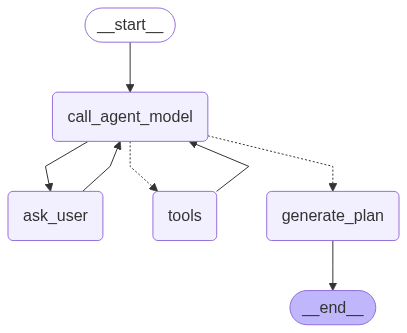

In [9]:
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(PlanningState)  # , config_schema=Configuration)

# Nodes
builder.add_node("call_agent_model", call_agent_model)
builder.add_node("ask_user", ask_user)
builder.add_node("tools", ToolNode(TOOLS))
builder.add_node("generate_plan", genereate_plan)

# Edges
builder.add_edge(START, "call_agent_model")
builder.add_edge("call_agent_model", "ask_user")
builder.add_edge("ask_user", "call_agent_model")

builder.add_conditional_edges(
    "call_agent_model",
    should_continue,
    ["tools", "generate_plan"],
)
builder.add_edge("tools", "call_agent_model")
# builder.add_edge("call_agent_model", "generate_plan")
builder.add_edge("generate_plan", END)


graph = builder.compile(
    # interrupt_before=["ask_user"],
    checkpointer=MemorySaver(),
    name="Planning Agent",
)
graph

In [ ]:
project_idea = "create plan to develop agentic AI note taking app using langgraph for my personal use (personal project for fun and learning) and i also want to show off my skills to my potenstial interviewer to get hired. it should take pictures of hand-written notes and it will automatically format the texts (it might contains equations and block diagrams) and find proper section in my notion and add this notes with proper format, first i just want to build normal python app and later of maybe i will try to create simple android app using flutter. "

In [11]:
messages = [HumanMessage(content=project_idea)]
# messages = graph.invoke({"project_description": messages}, config=thread)


In [12]:
# Run the graph until breakpoint

for event in graph.stream(
    {"project_description": messages}, thread, stream_mode="values"
):
    # event["messages"][-1].pretty_print()
    if event["messages"]:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

Before I proceed with creating a detailed project plan, I have a few clarification questions to ensure the plan aligns with your goals and constraints:

1. What is your preferred timeline for developing the MVP and subsequent features? Are there any specific deadlines you need to meet?
2. Do you have any existing infrastructure or tools (e.g., a Notion account, cloud storage) that you plan to integrate with this app?
3. Are there any specific libraries or frameworks you prefer or have experience with, especially for image processing and text recognition?
4. How familiar are you with Flutter for mobile app development, and do you have any preferences for the Android app's features or design?
5. Are there any budget constraints or resource limitations that I should be aware of while planning the project?
6. Do you have any specific requirements for the app's user interface or user experience?
7. Would you l

In [15]:
state = graph.get_state(thread)
print(state.next)


('ask_user',)


In [16]:
messages = [
    HumanMessage(
        content=""
        "1. no there is not any deadline. "
        "2.yes i have notion account and powerful personal pc with pop os. "
        "3. yes, i am computer vision engineer so i know opencv, pytorch, tensorflow and so on"
        "4.yes i know flutter"
        "5. yes. i want to complete the project as cheap as possible"
        "6. i am not sure, i have not thought about it yet, maybe i think think about it when i reach that point"
        "7. just english"
        "8. no, it is just a personal project for fun and automization of my notes"
    )
]
graph.update_state(thread, {"messages": messages})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f060d15-e301-6271-8002-7f6495b387c2'}}

In [17]:
for event in graph.stream(
    {"project_description": messages}, thread, stream_mode="values"
):
    # event["messages"][-1].pretty_print()
    if event["messages"]:
        event["messages"][-1].pretty_print()


================================ Human Message =================================

1. no there is not any deadline. 2.yes i have notion account and powerful personal pc with pop os. 3. yes, i am computer vision engineer so i know opencv, pytorch, tensorflow and so on4.yes i know flutter5. yes. i want to complete the project as cheap as possible6. i am not sure, i have not thought about it yet, maybe i think think about it when i reach that point7. just english8. no, it is just a personal project for fun and automization of my notes
================================== Ai Message ==================================

Thank you for the clarifications. Based on your responses, I'll create a detailed project plan for your personal project to automate your notes using computer vision and Flutter. Here's the plan:

# Project Plan: Note Automation App

## Overview
The project aims to develop a mobile application that automates the process of capturing and organizing notes using computer vision tec

KeyboardInterrupt: 